# The Battle of Neighborhoods (Week 2)

### 1. Introduction / Business Problem

In the UK, a total of 3.415.000 tonnes of waste is disposed of in the food sector every year, of which:
- 1.473.000 tonnes are sent for disposal.
- 600.000 tonnes (41%) of the waste from pubs, restaurants, hotels and quick service restaurants is food waste.
Some of this waste could supposedly be salvaged with better storage, preparation and portioning practices amongst food service professionals.

In this context, a solution could be to start a project of community restaurant in London aiming at reducing waste in the food sector.

Most of the activity could focus on the distribution of free price meals, offered on the basis of unsold food recovered from nearby restaurants. This model is meant to be as sustainable as possible. That's why the food collection should be done by bike.

One of the key element of the project is to decide what the best location for the community restaurant will be.

### 2. Data

This analysis must lead to find:
- the neighborhood with the highest concentration of restaurants
- the widest and most diverse offer of restaurants
- a central position among them to put the shortest distance between the local and the restaurants, distance that must be covered by bike.

In order to meet these needs, we will first get the dataset of all restaurants in London through the Foursquare API. On each restaurant, several information will be collected: name, category, address, coordinates (latitude, longitude), id, and the distance from a random address used to start the search.

Then, we will use the k-means clustering method to compare the different neighborhoods, determine the one meeting the requirements and find the best location in the selected neighborhood. The distance between the local and each restaurant around will be then easily calculated, as well as the time needed to cover the distance by bike.

Finally, a map will allow visualizing the results.

#### 2.1. Data acquisition

We first install the necessary librairies.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Then, we set up the Foursquare credentials.

In [2]:
CLIENT_ID = 'NC3E02KRS2IY3OJGCLGR0UX1WNII0EZ524NMFWFONCHPIJ0O' # your Foursquare ID
CLIENT_SECRET = 'IXI1NQPYJRAQTPJYUYU2YUMKSRW1LHGKSDPLA4CAUWPRNJQU' # your Foursquare Secret
VERSION = '20190530'
LIMIT = 500

To start the search of restaurants, we will choose randomly an address in the center of London and convert it into latitude and longitude coordinates.

In [3]:
address = 'SW1A 2DX, London, United Kingdom'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.5068953846639 -0.127788247275016


We can now search for restaurants around this address.

In [4]:
search_query = 'Restaurant'
radius = 15000

# Define the corresponding url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=NC3E02KRS2IY3OJGCLGR0UX1WNII0EZ524NMFWFONCHPIJ0O&client_secret=IXI1NQPYJRAQTPJYUYU2YUMKSRW1LHGKSDPLA4CAUWPRNJQU&ll=51.5068953846639,-0.127788247275016&v=20190530&query=Restaurant&radius=15000&limit=500'

In [5]:
# Send the GET request
results = requests.get(url).json()

Get relevant part of JSON and transform it into a *pandas* dataframe

In [6]:
# assign relevant part of JSON to venues
restaurants = results['response']['venues']

# tranform venues into a dataframe
df = json_normalize(restaurants)
df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d10e941735', 'name': 'G...",False,4ac518caf964a520bda520e3,13 Percy St,GB,London,United Kingdom,NaN,1315,"[13 Percy St, London, Greater London, W1T 1DP,...","[{'label': 'display', 'lat': 51.51827036363987...",51.518270,-0.132954,NaN,W1T 1DP,Greater London,The Elysee Restaurant and Roof Garden,v-1559379340,NaN
1,"[{'id': '52e81612bcbc57f1066b7a05', 'name': 'E...",False,5001b8e6e4b05e79b0b3b84d,36-44 Brewer St,GB,London,United Kingdom,Lexington St,746,"[36-44 Brewer St (Lexington St), Soho, Greater...","[{'label': 'display', 'lat': 51.51183377093123...",51.511834,-0.135080,NaN,W1F 9TB,Greater London,Bill's Restaurant,v-1559379340,NaN
2,"[{'id': '52e81612bcbc57f1066b7a05', 'name': 'E...",False,4d440bf1c3e5f04d0a219620,28 St Martin's Courtyard,GB,Covent Garden,United Kingdom,Upper St Martin's Ln,635,[28 St Martin's Courtyard (Upper St Martin's L...,"[{'label': 'display', 'lat': 51.51255465283461...",51.512555,-0.126600,NaN,WC2E 9AB,Greater London,Bill's Restaurant,v-1559379340,NaN
3,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,4af41e26f964a52024f021e3,St. Martin's Pl,GB,London,United Kingdom,Trafalgar Sq,264,"[St. Martin's Pl (Trafalgar Sq), London, Great...","[{'label': 'display', 'lat': 51.50925927272873...",51.509259,-0.128202,NaN,WC2N 4JJ,Greater London,Portrait Restaurant,v-1559379340,130427500
4,"[{'id': '4bf58dd8d48988d156941735', 'name': 'M...",False,4afc9a04f964a5204c2422e3,4-5 Rupert Court,GB,Chinatown,United Kingdom,NaN,569,"[4-5 Rupert Court, Chinatown, Greater London, ...","[{'label': 'display', 'lat': 51.51111126738831...",51.511111,-0.132445,Chinatown,W1D 6DY,Greater London,C&R Café Restaurant,v-1559379340,NaN


In [7]:
df.shape

(50, 19)

In [179]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
df_filter = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filter['categories'] = df_filter.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filter.columns = [column.split('.')[-1] for column in df_filter.columns]

df_filter.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Elysee Restaurant and Roof Garden,Greek Restaurant,13 Percy St,GB,London,United Kingdom,NaN,1315,"[13 Percy St, London, Greater London, W1T 1DP,...","[{'label': 'display', 'lat': 51.51827036363987...",51.518270,-0.132954,NaN,W1T 1DP,Greater London,4ac518caf964a520bda520e3
1,Bill's Restaurant,English Restaurant,36-44 Brewer St,GB,London,United Kingdom,Lexington St,746,"[36-44 Brewer St (Lexington St), Soho, Greater...","[{'label': 'display', 'lat': 51.51183377093123...",51.511834,-0.135080,NaN,W1F 9TB,Greater London,5001b8e6e4b05e79b0b3b84d
2,Bill's Restaurant,English Restaurant,28 St Martin's Courtyard,GB,Covent Garden,United Kingdom,Upper St Martin's Ln,635,[28 St Martin's Courtyard (Upper St Martin's L...,"[{'label': 'display', 'lat': 51.51255465283461...",51.512555,-0.126600,NaN,WC2E 9AB,Greater London,4d440bf1c3e5f04d0a219620
3,Portrait Restaurant,Café,St. Martin's Pl,GB,London,United Kingdom,Trafalgar Sq,264,"[St. Martin's Pl (Trafalgar Sq), London, Great...","[{'label': 'display', 'lat': 51.50925927272873...",51.509259,-0.128202,NaN,WC2N 4JJ,Greater London,4af41e26f964a52024f021e3
4,C&R Café Restaurant,Malay Restaurant,4-5 Rupert Court,GB,Chinatown,United Kingdom,NaN,569,"[4-5 Rupert Court, Chinatown, Greater London, ...","[{'label': 'display', 'lat': 51.51111126738831...",51.511111,-0.132445,Chinatown,W1D 6DY,Greater London,4afc9a04f964a5204c2422e3


#### 2.2. Data visualization

In [180]:
restaurant_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add the restaurants as blue circle markers
for lat, lng, label in zip(df_filter.lat, df_filter.lng, df_filter.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(restaurant_map)

# display map
restaurant_map

### 3. Methodology

#### 3.1. Exploratory analysis

We will first analyse the characteristics of the 49 restaurants found in the center of London.

In [181]:
# Repartition of restaurants by type
nb_restaurant = df_filter['categories'].value_counts()

In [183]:
type_restaurant = len(df_filter['categories'].unique())
print('The area counts {} different types of restaurants.'.format(type_restaurant))

The area counts 22 different types of restaurants.


We will remove those that are not in the taget: Café, Bar, Hotel Bar, College Cafeteria, Breakfast Spot.

In [184]:
# Café
df_filter.drop(df_filter[df_filter['categories'] ==  'Café'].index, inplace=True)

In [185]:
# Bar
df_filter.drop(df_filter[df_filter['categories'] ==  'Bar'].index, inplace=True)

In [186]:
# Hotel Bar
df_filter.drop(df_filter[df_filter['categories'] ==  'Hotel Bar'].index, inplace=True)

In [187]:
# College Cafeteria
df_filter.drop(df_filter[df_filter['categories'] ==  'College Cafeteria'].index, inplace=True)

In [188]:
# Breakfast spot
df_filter.drop(df_filter[df_filter['categories'] ==  'Breakfast Spot'].index, inplace=True)

In [189]:
df_filter.shape

(41, 16)

In [190]:
# Repartition of restaurants by type
nb_restaurant = df_filter['categories'].value_counts()

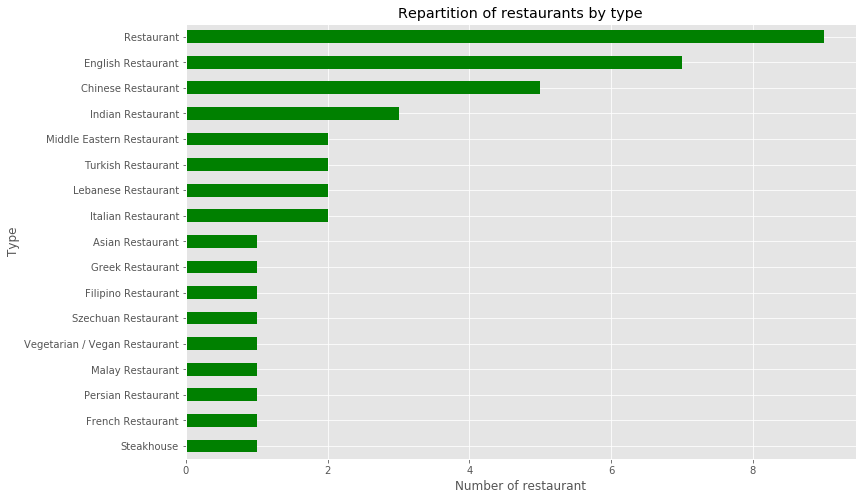

In [321]:
nb_restaurant.sort_values(ascending=True).plot(kind='barh', label='Number of restaurants', color='g', figsize=(12,8))

plt.title('Repartition of restaurants by type')
plt.xlabel('Number of restaurant')
plt.ylabel('Type')
plt.show()

#### 3.2. K-means clustering

At this point, we need to define what the best location for the community restaurant. The k-means clustering will allow us to find it out.

We will use three parameters:
<ul>
    <li> <b>init</b>: Initialization method of the centroids. </li>
    <li> <b>n_clusters</b>: The number of clusters to form as well as the number of centroids to generate. </li>
    <li> <b>n_init</b>: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
</ul>

k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.

To determine the number of clusters, the distance between the two most distant restaurants is calculated.

In [192]:
# The most western restaurant is a Persian restaurant (only one in the sample)
df_filter[df_filter['categories'] ==  'Persian Restaurant'].index

Int64Index([15], dtype='int64')

In [193]:
# Get the coordinates of this restaurant
lat0 = df_filter.loc[15,'lat']
long0 = df_filter.loc[15,'lng']
print('Persian Restaurant:\nlat: {} \nlong: {}'.format(lat0, long0))

Persian Restaurant:
lat: 51.514797985232526 
long: -0.16514838878436164


In [194]:
# The most eastern restaurant is a Turkish restaurant
df_filter[df_filter['categories'] ==  'Turkish Restaurant'].index

Int64Index([27, 43], dtype='int64')

In [195]:
# Get the coordinates of these restaurants
lat1 = df_filter.loc[27,'lat']
long1 = df_filter.loc[27,'lng']

lat2 = df_filter.loc[43,'lat']
long2 = df_filter.loc[43,'lng']

print('Turkish Restaurant 1:\nlat: {} \nlong: {}\n'.format(lat1, long1))
print('Turkish Restaurant 2:\nlat: {} \nlong: {}'.format(lat2, long2))

Turkish Restaurant 1:
lat: 51.51497241982951 
long: -0.09638114867926811

Turkish Restaurant 2:
lat: 51.515542025051815 
long: -0.08223122072221635


In [196]:
# Function calculating the distance between 2 coordinates
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
  # convert decimal degrees to radians 
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  r = 6371 # Radius of earth in kilometers. Use 3956 for miles
  return c * r

In [197]:
# Distance between west and Turkish restaurant 1
dist1 = haversine(lat0, long0, lat1, long1)
print('The distance between the Persian Restaurant and the Turkish Restaurant 1 is {} km.'.format(round(dist1, 2))) 

The distance between the Persian Restaurant and the Turkish Restaurant 1 is 7.65 km.


In [198]:
# Distance between west and Turkish restaurant 2
dist1 = haversine(lat0, long0, lat2, long2)
print('The distance between the Persian Restaurant and the Turkish Restaurant 2 is {} km.'.format(round(dist1, 2))) 

The distance between the Persian Restaurant and the Turkish Restaurant 2 is 9.22 km.


The distance between the community restaurant and the supply restaurants has to be covered by bike. That's why they must be located within a radius of 3 kilometres around it. As the distance between the most distant restaurants is 9.22 km, we will divide the 41 restaurants in 2 clusters.

__Define two arbitrary centers__

In [199]:
center1 = [51.510357, -0.134755]
center2 = [51.517949, -0.097287] 
centers = [center1, center2]

__Define a function that assigns each restaurant to a cluster__

In [245]:
df_index = df_filter.reset_index()
df_index.head()

,index,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,color
0,0,The Elysee Restaurant and Roof Garden,Greek Restaurant,13 Percy St,GB,London,United Kingdom,NaN,1315,"[13 Percy St, London, Greater London, W1T 1DP,...","[{'label': 'display', 'lat': 51.51827036363987...",51.518270,-0.132954,NaN,W1T 1DP,Greater London,4ac518caf964a520bda520e3,g
1,1,Bill's Restaurant,English Restaurant,36-44 Brewer St,GB,London,United Kingdom,Lexington St,746,"[36-44 Brewer St (Lexington St), Soho, Greater...","[{'label': 'display', 'lat': 51.51183377093123...",51.511834,-0.135080,NaN,W1F 9TB,Greater London,5001b8e6e4b05e79b0b3b84d,g
2,2,Bill's Restaurant,English Restaurant,28 St Martin's Courtyard,GB,Covent Garden,United Kingdom,Upper St Martin's Ln,635,[28 St Martin's Courtyard (Upper St Martin's L...,"[{'label': 'display', 'lat': 51.51255465283461...",51.512555,-0.126600,NaN,WC2E 9AB,Greater London,4d440bf1c3e5f04d0a219620,g
3,4,C&R Café Restaurant,Malay Restaurant,4-5 Rupert Court,GB,Chinatown,United Kingdom,NaN,569,"[4-5 Rupert Court, Chinatown, Greater London, ...","[{'label': 'display', 'lat': 51.51111126738831...",51.511111,-0.132445,Chinatown,W1D 6DY,Greater London,4afc9a04f964a5204c2422e3,g
4,5,The Ivy Restaurant,English Restaurant,1-5 West St,GB,London,United Kingdom,Litchfield St,657,"[1-5 West St (Litchfield St), London, Greater ...","[{'label': 'display', 'lat': 51.51279973860704...",51.512800,-0.127981,NaN,WC2H 9NQ,Greater London,4b5344aef964a5200c9527e3,g


In [246]:
df_index.drop(['index'], axis=1, inplace=True)

In [225]:
def assign_restaurant(x1, x2):
    colors_map = []

    for i in range(len(x1)):
        distance_to_center_1 = haversine(x1[i], x2[i], centers[0][0], centers[0][1])
        distance_to_center_2 = haversine(x1[i], x2[i], centers[1][0], centers[1][1])
        
        if distance_to_center_1 > distance_to_center_2:
            colors_map.append('green')
        else:
            colors_map.append('red')
    
    return colors_map

__Define a function that updates the centroid of each cluster__

In [262]:
def update_centers():
    lat_mean = df_index.groupby(['color'])['lat'].mean()
    lng_mean = df_index.groupby(['color'])['lng'].mean()
    center1 = [lat_mean[1], lng_mean[1]]
    center2 = [lat_mean[0], lng_mean[0]]
    return [center1, center2]

__Repeat the process until the position of the centroids is stable__

In [263]:
number_of_iterations = 10
for i in range(number_of_iterations):
    
    # Recalculate the position of the centers
    centers = update_centers()
    
    # Save the color in a column
    df_index['color'] = assign_restaurant(df_index['lat'], df_index['lng'])
    

### 4. Results

In [267]:
print('The coordinates of the two best locations for the community restaurant are: \nLocation 1: {}\nLocation 2: {}'.format(
center1, center2))

The coordinates of the two best locations for the community restaurant are: 
Location 1: [51.510357, -0.134755]
Location 2: [51.517949, -0.097287]


__Map of the clusters__

In [289]:
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add the restaurants of each cluster
for lat, lng, color in zip(df_index.lat, df_index.lng, df_index.color):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=color,
        fill = True,
        fill_opacity=0.6
    ).add_to(cluster_map)

# add a red circle marker to represent the center of the red cluster, potential location of the community restaurant
folium.features.CircleMarker(
    [center1[0], center1[1]],
    radius=10,
    color='black',
    popup='Location 1',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.8
).add_to(cluster_map)

# add a green circle marker to represent the center of the green cluster, potential location of the community restaurant
folium.features.CircleMarker(
    [center2[0], center2[1]],
    radius=10,
    color='black',
    popup='Location 2',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.8
).add_to(cluster_map)

# display map
cluster_map

__Comparision of the two clusters__

In [298]:
# Number of restaurants in each cluster
rest = df_index['color'].value_counts()

In [304]:
# Number of different type of restaurant
type = df_index.groupby(['color'])['categories'].unique()

In [311]:
# Average distance from the community restaurant
def distance_center(x1, x2):
    distance = []

    for i in range(len(x1)):
        distance_to_center_1 = haversine(x1[i], x2[i], centers[0][0], centers[0][1])
        distance_to_center_2 = haversine(x1[i], x2[i], centers[1][0], centers[1][1])
        
        if distance_to_center_1 > distance_to_center_2:
            distance.append(distance_to_center_2)
        else:
            distance.append(distance_to_center_1)
    
    return distance

In [312]:
df_index['distance to center'] = distance_center(df_index['lat'], df_index['lng'])

In [315]:
avg = df_index.groupby(['color'])['distance to center'].mean()

In [319]:
print('--- RED CLUSTER ---\nNumber of restaurants: {}\nDifferent type of restaurants: {}\nAverage distance from the community restaurant: {}km'.format(rest[0], len(type[1]), round(avg[1], 2)))

--- RED CLUSTER ---
Number of restaurants: 29
Different type of restaurants: 14
Average distance from the community restaurant: 1.42km


In [320]:
print('--- GREEN CLUSTER ---\nNumber of restaurants: {}\nDifferent type of restaurants: {}\nAverage distance from the community restaurant: {}km'.format(rest[1], len(type[0]), round(avg[0], 2)))

--- GREEN CLUSTER ---
Number of restaurants: 12
Different type of restaurants: 6
Average distance from the community restaurant: 1.06km


### 5. Discussion

The red cluster appears to be the one meeting all the requirements for the creation of a community restaurant in the center of London. It gathers the biggest amount of restaurants and the widest offer with 14 different type. Besides, the average distance of 1.42 kms between the restaurants and the center could be easily covered by bike. With an average speed of 15 km/h in town, it would take around 6 min to reach each destination.

### 6. Conclusion

This analysis has allowed to identify the opportunity to start a social project such as a community restaurant in the center of London to reduce waste in the food sector. It could be combine with a real estate analysis.